# Guide on Creating Metadata for V3 and Performing Data Query and Extraction

Author: [Wong Songhan](mailto:songhan89@gmail.com)

Date: 16-06-2024

## Introduction

This guide demonstrates how to use `xarray`, `zarr`, and `Virtualizarr` to create a virtual dataset of V3 data stored in a virtual Zarr format. This approach facilitates efficient data querying and extraction. For computation, we use `dask` to parallelize the data extraction process.

For insights into the rationale behind these technology choices, refer to the following link:
* [Problem with Data Access for Large-Scale Weather and Climate Data](https://tomaugspurger.net/noaa-nwm/02-problems.html)

The guide shown here is using a local file system and local Dask cluster. The same idea would also work with cloud storage and cloud Dask cluster.

## Prerequisites

- Python 3.10 or higher

## Installation

To install the required packages, run the following command:

```bash
pip install xarray[complete] kerchunk dask dask-gateway
```

To install the Virtualizarr package, use these commands:

```bash
git clone https://github.com/TomNicholas/VirtualiZarr
cd VirtualiZarr
pip install .
```

## Virtualizarr

In this guide, we use [Virtualizarr](https://virtualizarr.readthedocs.io/en/latest/) instead of Kerchunk to create a virtual dataset. Virtualizarr simplifies the technical complexity of Kerchunk, offering a more user-friendly interface.

For those interested in using Kerchunk, here are some useful resources:
* [Using Kerchunk](https://tomaugspurger.net/noaa-nwm/03-using-kerchunk.html)
* [Kerchunk Cookbook](https://github.com/ProjectPythia/kerchunk-cookbook)

## Dask Cluster

This guide uses a local Dask cluster. For scalable TB-scale workloads, consider setting up a dedicated Dask cluster using Azure Kubernetes Service (AKS).

Microsoft Planetary Computer provides an excellent guide on setting up a Dask cluster on Azure, which you can find here:
* [Setting up Dask Cluster on Azure](https://planetarycomputer.microsoft.com/docs/concepts/hub-deployment/)

In [22]:
import xarray as xr
from glob import glob
from virtualizarr import open_virtual_dataset

### Part 1: Creating Metadata for V3 Data

First, we need to create metadata for the V3 data. This is a one-time process that involves creating a virtual dataset that points to the netcdf data.

In [23]:
# check size of the dataset
!du -sh ./data/

 14G	./data/


In [24]:
# find all *.nc files in the data folder recursively
files = glob('data/**/*.nc', recursive=True)
files = sorted(files)
files[:3]

['data/2015/pr_V3-SEA-8_ACCESS-CM2_ssp585_r4i1p1f1_SINGV-RCM_vn5_day_20150101-20150131.nc',
 'data/2015/pr_V3-SEA-8_ACCESS-CM2_ssp585_r4i1p1f1_SINGV-RCM_vn5_day_20150201-20150228.nc',
 'data/2015/pr_V3-SEA-8_ACCESS-CM2_ssp585_r4i1p1f1_SINGV-RCM_vn5_day_20150301-20150331.nc']

Now, we will be reading the metadata from the V3 netcdf data. This is a lazy operation and does not load the full datasets.

In [25]:
# open all files as virtual datasets
# this is a lazy operation, no data is read yet
list_of_virtual_datasets = [open_virtual_dataset(f) for f in files]
list_of_virtual_datasets[:2]

[<xarray.Dataset> Size: 78MB
 Dimensions:  (time: 31, lat: 560, lon: 1120)
 Coordinates:
   * lat      (lat) float64 4kB ManifestArray<shape=(560,), dtype=float64, chu...
   * lon      (lon) float64 9kB ManifestArray<shape=(1120,), dtype=float64, ch...
   * time     (time) float64 248B ManifestArray<shape=(31,), dtype=float64, ch...
 Data variables:
     pr       (time, lat, lon) float32 78MB ManifestArray<shape=(31, 560, 1120...
 Attributes: (12/20)
     CDI:                            Climate Data Interface version 2.2.1 (htt...
     CDO:                            Climate Data Operators version 2.2.0 (htt...
     Conventions:                    CF-1.6
     NCO:                            netCDF Operators version 4.9.9 (Homepage ...
     V3_domain:                      V3-SEA-8
     cdo_openmp_thread_number:       24
     ...                             ...
     institute_id:                   CCRS
     model_id:                       SINGV-RCM
     product:                        ou

In [5]:
# preview one of the datasets as a xarray dataset
list_of_virtual_datasets[0]

<xarray.Dataset> Size: 78MB
Dimensions:  (time: 31, lat: 560, lon: 1120)
Coordinates:
  * lat      (lat) float64 4kB ManifestArray<shape=(560,), dtype=float64, chu...
  * lon      (lon) float64 9kB ManifestArray<shape=(1120,), dtype=float64, ch...
  * time     (time) float64 248B ManifestArray<shape=(31,), dtype=float64, ch...
Data variables:
    pr       (time, lat, lon) float32 78MB ManifestArray<shape=(31, 560, 1120...
Attributes: (12/20)
    CDI:                            Climate Data Interface version 2.2.1 (htt...
    CDO:                            Climate Data Operators version 2.2.0 (htt...
    Conventions:                    CF-1.6
    NCO:                            netCDF Operators version 4.9.9 (Homepage ...
    V3_domain:                      V3-SEA-8
    cdo_openmp_thread_number:       24
    ...                             ...
    institute_id:                   CCRS
    model_id:                       SINGV-RCM
    product:                        output
    project_id:                     V3
    rcm_version_id:                 RA1T-D8
    source:                         Met Office Unified Model v11.1

## Step 2: Combine the virtual datasets into a single dataset

Now that we have loaded the individual netCDF files into a virtual datasets, we can combine them into a single dataset. This is done by saving a json metadata that describes the full set of virtual datasets. This json metadata can be used to load the full virtual dataset in the future.

In [17]:
temp_ds = list_of_virtual_datasets[0]

for ds in list_of_virtual_datasets[1:]:
    temp_ds = xr.concat([temp_ds, ds], dim='time')

virtual_ds = temp_ds

In [22]:
virtual_ds.virtualize.to_kerchunk('v3_combined.json', format='json')

## Step 3: Load the combined virtual datasets 

Now, let's pretend that we are a user who wish to do perform slice and dice operations on the combined dataset. 
We can load the combined virtual dataset using the xarray `open_dataset` function and perform operations on it.

You can see that we can load the entire dataset in a lazy manner quickly.

In [1]:
import xarray as xr
from dask.distributed import Client, LocalCluster

# Set up a local Dask cluster with a memory limit for each worker (e.g., 2 GB per worker)
cluster = LocalCluster(n_workers=4, memory_limit='2GB')
client = Client(cluster)

In [2]:
#client.start()
#client.shutdown()

In [3]:
# click on URL below to view the Dask dashboard
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54503,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:54517,Total threads: 3
Dashboard: http://127.0.0.1:54520/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:54506,


In [4]:
# load the virtual dataset as a xarray dataset and sort by time
import xarray as xr
# you may need to experiment with the chunk size to find the optimal value, depending on the configuration of your cluster
v3_ds = xr.open_dataset('v3_combined.json', engine="kerchunk", chunks={
    'time': 20,
    'lat': 20,
    'lon': 20
}).sortby('time')

/Users/songhanwong/anaconda3/envs/py311/lib/python3.11/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 20. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/Users/songhanwong/anaconda3/envs/py311/lib/python3.11/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 20. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [5]:
# check the size of the combined dataset
print (f"Size of data: {v3_ds.nbytes / 1e9} GB")

Size of data: 21.076509448 GB


## Step 4: Perform data query and extraction

In this case, we will extract the data for a specific time range and spatial extent. This is done by using the `sel` method in xarray.

In [6]:
# select a subset of the data
lon_min, lon_max = 90, 100
lat_min, lat_max = -10, 10
time_min, time_max = '2015-01-01', '2015-12-31'
v3_ds_subset = v3_ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max), time=slice(time_min, time_max))

We can now preview the metadata of the extracted data. No operation has been done on the data yet.

In [8]:
v3_ds_subset

<xarray.Dataset> Size: 56MB
Dimensions:  (lat: 278, lon: 139, time: 365)
Coordinates:
  * lat      (lat) float64 2kB -9.968 -9.896 -9.824 -9.752 ... 9.832 9.904 9.976
  * lon      (lon) float64 1kB 90.05 90.12 90.19 90.26 ... 99.84 99.91 99.98
  * time     (time) datetime64[ns] 3kB 2015-01-01 2015-01-02 ... 2015-12-31
Data variables:
    pr       (time, lat, lon) float32 56MB dask.array<chunksize=(20, 14, 16), meta=np.ndarray>
Attributes: (12/20)
    CDI:                            Climate Data Interface version 2.2.1 (htt...
    CDO:                            Climate Data Operators version 2.2.0 (htt...
    Conventions:                    CF-1.6
    NCO:                            netCDF Operators version 4.9.9 (Homepage ...
    V3_domain:                      V3-SEA-8
    cdo_openmp_thread_number:       24
    ...                             ...
    institute_id:                   CCRS
    model_id:                       SINGV-RCM
    product:                        output
    project_id:                     V3
    rcm_version_id:                 RA1T-D8
    source:                         Met Office Unified Model v11.1

## Step 5: Perform data extraction and export to netcdf

Finally, we can extract the data and export it to a netcdf file. This is done by using the `to_netcdf` method in xarray.

When you run this code, you will see that the data extraction process is parallelized using Dask. This is because we are using a Dask cluster to perform the data extraction.

<img src='./images/dask-compute.png' width='50% px'></img>

In [ ]:
# if file does not exist, save the subset to a netcdf file
# else delete it 
import os

try:
    v3_ds_subset.to_netcdf('./output/v3_subset.nc')
except:
    os.remove('./output/v3_subset.nc')
    v3_ds_subset.to_netcdf('./output/v3_subset.nc')

## Final Step: Inspect the extracted netCDF data

Now that our data is saved to a netCDF file, we can inspect it using xarray and matplotlib.

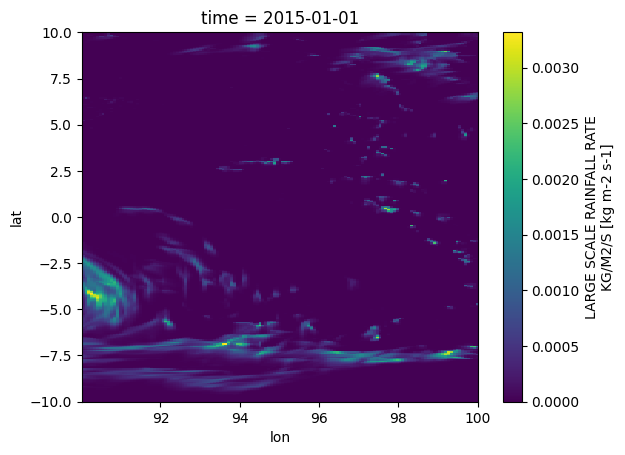

In [20]:
import xarray as xr


# open the extracted netcdf file

v3_ds_subset = xr.open_dataset('./output/v3_subset.nc')
v3_ds_subset.sel(time='2015-01-01').pr.plot()

In [ ]:
# shutdown the Dask cluster
client.shutdown()